<h1>RQ2 - How do clients respond to in-range breaking updates?</h1>

<h2>Motivation</h2>
<p>
The time needed to first respond and eventually resolve an in-range breaking build issue is an important property, as the longer these issues remain unaddressed, the higher the likelihood of one of the package users will attempt and fail to build their project. Ideally, the changes that are needed to resolve an in-range breaking build issue should be as low impact as possible, as the higher the effort required to resolve the in-range breaking build, the longer the time to resolve the issue will be. It may in fact be the case that in-range breaking build issue reports are sometimes false alarms, in which case these issue reports are serving only to discredit legitimate in-range breaking build issue reports and burden package maintainers with a high number of misleading notifications and interrupt their workflows, which is a common complaint from developers who integrate tools into their projects (Brown and Parnin, 2020; Mirhosseini and Parnin, 2017; Wessel et al., 2018). In these scenarios, developers might lose trust in automated dependency management bots like Greenkeeper and begin to interpret these tools as more of an annoyance than a convenience. So, to advance our insights, we study both the time it takes to close in-range breaking build issue reports and the types of changes (if any) developers are making in their projects to resolve in-range breaking build issue reports. Therefore, in this RQ, we investigate 1) how often are in-range breaking build issue reports resolved (i.e., not closed vs. closed)?, 2) how long does it take developers to respond to in-range breaking build issue reports?, and 3) how are in-range breaking build issue reports resolved?
</p>

<h2>Approach</h2>
<p>
We calculate the proportion of in-range breaking build issue reports that are closed and calculate the time difference (in days) between the creation date and the close date for closed issues to measure the amount of time it takes for in-range breaking build issue reports to be closed. We use the same process to measure the proportion of in-range breaking build issues that have a comment from a developer and the time difference (in days) between the creation date of the issue report and the creation date of the comment so determine how often and how fast package maintainers respond to these issue reports.
</p>
<p>
We also examine all comments left by developers on in-range breaking build issue reports opened in their projects in an effort to evaluate whether developers find this tool to be useful. We classified these comments using regular expressions to match specific phrases and patterns. We initially label all user comments as unclassified, and then progressively examine a sample of unclassified comments, manually extracting common phrases and patterns that can be grouped into similar categories, repeating the process until none of the remaining unclassified comments can be cleanly grouped into a similar category.
</p>
<p>
We look at the effectiveness of Greenkeeper's automatic attempts at pinning the breaking dependency as a first attempt to resolve the client's build. Greenkeeper will automatically attempt to pin the breaking dependency when the issue report is first opened, and will comment on the issue report stating whether the pin was successful. If the pin is not successful, the client must manually resolve the issue by either adapting their codebase to be compatible with the new release of the dependency, or by downgrading to an earlier version of the dependency with which their project is compatible. We determine whether the pin attempt was successful by searching for the patterns shown in Table 3.
</p>

<table>
    <thead>
        <tr>
            <th>Type</th>
            <th>Pattern</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Failed Pin Attempt</td>
            <td>"your tests are still failing"</td>
        </tr>
        <tr>
            <td>Successful Pin Attempt</td>
            <td>"your tests are passing again"</td>
        </tr>
    </tbody>
</table>

<p>
Finally, to gain insight into how the in-range breaking build issue reports are resolved, we examine the commits that are referenced by developers on the issue reports. We hypothesize that the referenced changes will be relatively small, both in terms of number of individual files changed, as well as number of individual lines changed, since package maintainers would be looking to fix the issue as efficiently as possible. To that end, we look at which files are changed in the commit and analyze the file diff to determine the number of lines added and number of lines removed for each commit.    
</p>


<h2>Findings</h2>
<ul>
    <li><b>Finding) TODO</b></li>
</ul>

<h3>Load helper functions</h3>

In [657]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [658]:
issues = load_issues()

<h3>Load <code>all_issues</code></h3>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>

Count=2398438 (Project Count=12017) Median=55.0 Mean=199.58708496296913


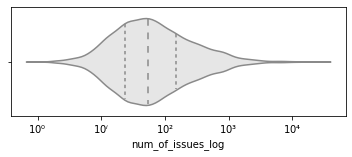

In [659]:
all_issues = load_all_issues()
counts = all_issues.groupby('repo_name')['id'].count()
print(f"Count={len(all_issues)} (Project Count={len(counts)}) Median={counts.median()} Mean={counts.mean()}")
for_plot = counts.to_frame(name='num_of_issues')
for_plot['placeholder'] = ''
for_plot['num_of_issues_log'] = np.log10(for_plot['num_of_issues'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=for_plot,
    x='num_of_issues_log',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
    logscale=True
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(log10_func_formatter)
plt.show()

<h3>Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [660]:
def filter_issues_for_analyses(all_issues, gk_issues):
    # Make copies
    gk_issues_for_analysis = gk_issues.copy()
    non_gk_issues_for_analysis = all_issues.copy()
    # Remove pull requests from all issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['is_pull_request']
    ]
    # Filter out any issues that are GK in-range breakin gbuild issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['id'].isin(gk_issues_for_analysis['id'])
    ]
    # Only analyze GK issues for projects we have all issues for
    gk_issues_for_analysis = gk_issues_for_analysis[
        gk_issues_for_analysis['repo_name'].isin(non_gk_issues_for_analysis['repo_name'])
    ]
    # Copy the html_url and body attributes over from all_issues to their respective rows on gk_issues
    gk_issues_for_analysis = gk_issues_for_analysis.merge(
        all_issues[['id', 'html_url', 'body']],
        how='left',
        on='id',
    )
    return non_gk_issues_for_analysis, gk_issues_for_analysis
    

non_gk_issues, gk_issues = filter_issues_for_analyses(all_issues, issues)

<h3><b><i>What proportion of in-range breaking build issue reports are closed (i.e., resolved)?</i></b></h3>

In [661]:
proportions = (
    issues['state'].value_counts() / 
    issues['state'].count()
).to_frame(name='proportion')\
    .rename_axis('state')\
    .reset_index()
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
proportions.head()

--All GK in-range breaking issue state proportions (not calculated per project)--


,state,proportion
0,closed,0.798242
1,open,0.201758


--Intra-project comparison for proportion of closed issues & proportion of closed GK in-range breaking build issues--
Proportion of closed issues      Count    Mean    STD    Min    25%    Median    75%    Max
-----------------------------  -------  ------  -----  -----  -----  --------  -----  -----
proportion_non_gk                 7290   0.826  0.209  0.026    0.7     0.905      1      1
proportion_gk                     7290   0.909  0.211  0.022    1       1          1      1



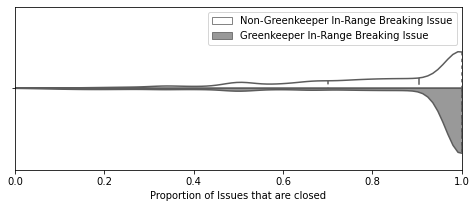

In [662]:
non_gk_issues__state_proportions = (
    (
        non_gk_issues.groupby('repo_name', observed=True)['state'].value_counts() / 
        non_gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)
gk_issues__state_proportions = (
    (
        gk_issues.groupby('repo_name')['state'].value_counts() / 
        gk_issues.groupby('repo_name')['state'].count()
    ).to_frame(name='proportion').reset_index()
)

project_issue__state_proportions = non_gk_issues__state_proportions.merge(
    gk_issues__state_proportions,
    how='inner',
    on=['repo_name', 'state'],
    suffixes=['_non_gk', '_gk'],
)
project_issue__state_proportions['ratio'] = project_issue__state_proportions['proportion_gk'] / project_issue__state_proportions['proportion_non_gk']
project_issue__state_proportions__closed = project_issue__state_proportions[project_issue__state_proportions['state'] == 'closed']

melted = pd.melt(
    project_issue__state_proportions__closed,
    id_vars='repo_name',
    value_vars=['proportion_non_gk', 'proportion_gk'],
    var_name='proportion_type',
    value_name='proportion',
)
melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='proportion',
    y='placeholder',
    hue='proportion_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Proportion of Issues that are closed')
ax.set_xlim(0, 1)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for proportion of closed issues & proportion of closed GK in-range breaking build issues--')
tfns(project_issue__state_proportions__closed, ['proportion_non_gk', 'proportion_gk'], title='Proportion of closed issues')
plt.show()

In [663]:
# TODO: Statistical test

<h4>Project ratio between proportion of closed non-gk issues and gk issues</h4>

--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--
         Count    Mean    STD    Min    25%    Median    75%    Max
-----  -------  ------  -----  -----  -----  --------  -----  -----
ratio     7290   1.224  0.729  0.022      1     1.022  1.321     19



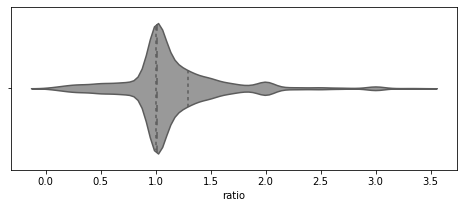

In [664]:
for_plot = project_issue__state_proportions__closed[['ratio']].copy()
for_plot = filter_outliers(for_plot, col='ratio', threshold=3)
for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax = sns.violinplot(
    data=for_plot,
    x='ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
    scale='width'
)
ax.set_ylabel('')
# ax.set_xlim(0, 2)
print('--Intra-project comparison for ratio of a projects proportion of closed GK issues to proportion of closed non-gk issues--')
tfns(project_issue__state_proportions__closed, ['ratio'])
plt.show()

<h3><b><i>How long does it take for in-range breaking build issue reports to be closed (i.e., resolved)?</i></b></h3>

--All GK in-range breaking issue state proportions (not calculated per project)--
                 Count  Mean              STD               Min              25%              Median           75%               Max
-------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_close    98341  43 days 04:48:29  98 days 22:44:48  0 days 00:00:04  0 days 09:58:19  4 days 11:04:25  35 days 07:48:16  1219 days 02:01:10



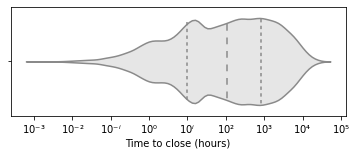

In [665]:
closed_issues = issues[issues['state'] == 'closed'][['created_at', 'closed_at']]
closed_issues['time_to_close'] = closed_issues['closed_at'] - closed_issues['created_at']
closed_issues['time_to_close_hours'] = closed_issues['time_to_close'] / np.timedelta64(1, 'h')
closed_issues['log_time_to_close_hours'] = np.log10(closed_issues['time_to_close_hours'])
closed_issues['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=closed_issues,
    x='log_time_to_close_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to close (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
print('--All GK in-range breaking issue state proportions (not calculated per project)--')
tfns(closed_issues, ['time_to_close'])
plt.show()

/home/local/SAIL/benjamin/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--


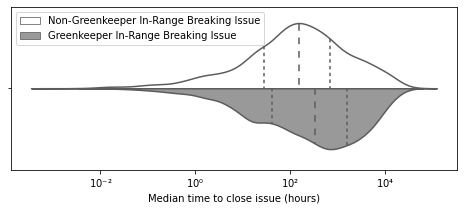

Median time to close issue      Count  Mean              STD                Min              25%              Median            75%               Max
----------------------------  -------  ----------------  -----------------  ---------------  ---------------  ----------------  ----------------  ------------------
median_non_gk                    7290  49 days 00:04:46  127 days 16:11:47  0 days 00:00:03  1 days 04:16:50  6 days 05:58:38   28 days 19:27:22  2097 days 11:47:18
median_gk                        7710  61 days 23:32:22  118 days 17:34:01  0 days 00:00:28  1 days 16:36:01  13 days 21:29:07  63 days 18:26:16  1130 days 03:37:18



In [666]:
# Calculate mean and median intra-project time_to_close for Non-GK issues
non_gk_issues__closed = non_gk_issues[non_gk_issues['state'] == 'closed'].copy()
non_gk_issues__closed['time_to_close'] = (
    non_gk_issues__closed['closed_at'] - non_gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__non_gk_issue__time_to_close = (
    non_gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
)
project__non_gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['mean'],
    unit='s'
)
project__non_gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__non_gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__non_gk_issue__time_to_close['median'],
    unit='s'
)
project__non_gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__non_gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)

# Calculate mean and median intra-project time_to_close for GK issues
gk_issues__closed = gk_issues[gk_issues['state'] == 'closed'].copy()
gk_issues__closed['time_to_close'] = (
    gk_issues__closed['closed_at'] - gk_issues__closed['created_at']
).dt.total_seconds()  # Have to convert to seconds to calculate mean and median
project__gk_issue__time_to_close = (
    gk_issues__closed
        .groupby('repo_name')['time_to_close']
        .agg(['mean', 'median'])
        .reset_index()
)
project__gk_issue__time_to_close['mean'] = pd.to_timedelta(
    project__gk_issue__time_to_close['mean'],
    unit='s'
)
project__gk_issue__time_to_close['mean_hours_log'] = np.log10(
    project__gk_issue__time_to_close['mean'] / np.timedelta64(1, 'h')
)
project__gk_issue__time_to_close['median'] = pd.to_timedelta(
    project__gk_issue__time_to_close['median'],
    unit='s'
)
project__gk_issue__time_to_close['median_hours_log'] = np.log10(
    project__gk_issue__time_to_close['median'] / np.timedelta64(1, 'h')
)

# Merge the two
project__all_issues__time_to_close = project__non_gk_issue__time_to_close.merge(
    project__gk_issue__time_to_close,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)

# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_close,
    id_vars='repo_name',
    value_vars=['median_hours_log_non_gk', 'median_hours_log_gk'],
    var_name='issue_type',
    value_name='median_time_to_close_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='median_time_to_close_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to close issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for median time to close issues & median time to close GK in-range breaking build issues--')
%run _utils.ipynb
tfns(project__all_issues__time_to_close, ['median_non_gk', 'median_gk'], title='Median time to close issue')
plt.show()

--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--
                Count     Mean      STD    Min    25%    Median     75%     Max
------------  -------  -------  -------  -----  -----  --------  ------  ------
median_ratio     7290  808.67   12013.5      0  0.239     1.575  12.023  566938
mean_ratio       7290  616.496  11735.8      0  0.141     0.698   3.317  623097



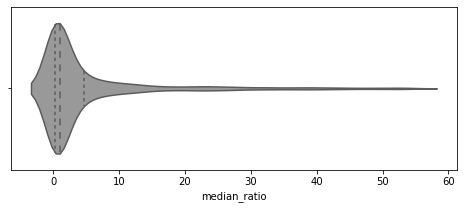

In [667]:
project__all_issues__time_to_close['median_ratio'] = (
    project__all_issues__time_to_close['median_gk'] / 
    project__all_issues__time_to_close['median_non_gk']
)
project__all_issues__time_to_close['mean_ratio'] = (
    project__all_issues__time_to_close['mean_gk'] / 
    project__all_issues__time_to_close['mean_non_gk']
)
for_plot = project__all_issues__time_to_close[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to close GK issues vs median time to close non-GK issues--')
tfns(project__all_issues__time_to_close, ['median_ratio', 'mean_ratio'])
plt.show()

<h2><b>Comments</b></h2>

In [668]:
comments = load_comments()
NOT_CLASSIFIED = 'Other'
# Set all comments to 'Not Classified'
comments['comment_classification'] = NOT_CLASSIFIED

<h3><b><i>How many comments to in-range breaking build issue reports have in total and from actual developers?</i></b></h3>

In [669]:
proportions = (
    comments['comment_user_type'].value_counts() / 
    comments['comment_user_type'].count()
).to_frame(name='proportion')\
    .rename_axis('comment_user_type')\
    .reset_index()
print(proportions.head())

def get_issue_comment_count(df):
    return df.groupby('comment_issue_id')['comment_id']\
        .count()\
        .to_frame(name='num_of_comments')\
        .reset_index()

counts = get_issue_comment_count(comments)
tfns(counts, ['num_of_comments'], should_round=False, title='Number of comments on In-Range issues')

user_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'User'])
tfns(user_counts, ['num_of_comments'], should_round=False, title='Number of user comments on In-Range issues')

bot_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'Bot'])
tfns(bot_counts, ['num_of_comments'], should_round=False, title='Number of bot comments on In-Range issues')


  comment_user_type  proportion
0               Bot    0.970669
1              User    0.029331
Number of comments on In-Range issues      Count     Mean      STD    Min    25%    Median    75%    Max
---------------------------------------  -------  -------  -------  -----  -----  --------  -----  -----
num_of_comments                            99581  3.67163  5.40044      1      1         2      4     30

Number of user comments on In-Range issues      Count     Mean       STD    Min    25%    Median    75%    Max
--------------------------------------------  -------  -------  --------  -----  -----  --------  -----  -----
num_of_comments                                  9854  1.08829  0.646108      1      1         1      1     28

Number of bot comments on In-Range issues      Count     Mean      STD    Min    25%    Median    75%    Max
-------------------------------------------  -------  -------  -------  -----  -----  --------  -----  -----
num_of_comments                     

In [670]:
users_comments = comments[comments['comment_user_type'] == 'User'].copy().reset_index(drop=True)
issues_with_user_comment = \
    gk_issues[gk_issues['id']\
        .isin(users_comments['comment_issue_id'])]\
        .copy()\
        .reset_index(drop=True)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(gk_issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')

9.3% of in-range issues have a comment from a user.


<h3><b><i>How long does it take for users to comment?</i></b></h3>

                   Count  Mean              STD               Min              25%              Median           75%               Max
---------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_comment     9652  25 days 17:24:11  65 days 08:20:06  0 days 00:00:01  0 days 08:17:24  2 days 12:57:58  18 days 16:46:52  1039 days 05:34:55



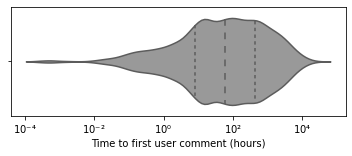

In [671]:
users_comments_simplified = users_comments[['comment_issue_id', 'comment_created_at']]
users_comments_simplified = \
    users_comments_simplified\
        .groupby('comment_issue_id')['comment_created_at']\
        .min()\
        .to_frame()\
        .reset_index()
issues_simplified = gk_issues[['id', 'created_at']]

merged = issues_simplified.merge(
    users_comments_simplified,
    left_on='id',
    right_on='comment_issue_id'
)
merged['time_to_comment'] = merged['comment_created_at'] - merged['created_at']

merged['time_to_comment_hours'] = merged['time_to_comment'] / np.timedelta64(1, 'h')
merged = merged[~(merged['time_to_comment_hours'] == 0)]
merged['log_time_to_comment_hours'] = np.log10(merged['time_to_comment_hours'])
merged['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=merged,
    x='log_time_to_comment_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to first user comment (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
tfns(merged, ['time_to_comment'])
plt.show()

In [681]:
# Writing out CSV
# for_csv = non_gk_issues[['id', 'repo_name', 'comments_url']]
# for_csv.to_csv(f'../csv/issues_to_collect_comments_for.csv', index=False)

<h2><b>Pinning</b></h2>

<h3><b><i>How successful is auto-pinning the dependency?</i></b></h3>

In [672]:
pinning_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]') &
        (comments['comment_body'].str.contains('After pinning to', case=False))
    )
][['comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status = pinning_comments.merge(
    gk_issues[['id', 'url', 'title', 'html_url', 'body']],
    left_on='comment_issue_id',
    right_on='id'
)
# Re-order columns
issue_pin_status = issue_pin_status[['id', 'url', 'title', 'html_url', 'body', 'comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status['pin_status'] = 'unknown'
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_string = '|'.join([
    "your tests are passing again"
])
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_success_string, case=False),
    'pin_status'
] = 'success'
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_fail_string, case=False),
    'pin_status'
] = 'failure'

issue_pin_status['pin_status'].value_counts()

proportions = (
    issue_pin_status['pin_status'].value_counts() / 
    issue_pin_status['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--How successful is pinning the dependency?--')
proportions.head()

--How successful is pinning the dependency?--


,pin_status,proportion
0,failure,0.676202
1,success,0.323798


<h4>Write out cases for manual analysis</h4>

In [688]:
failed_pins = issue_pin_status[issue_pin_status['pin_status'] == 'failure']
sample_failed_pins = failed_pins.sample(n=500, random_state=42)
sample_failed_pins.to_csv(f'./manual_analysis/failed_pins/sample_failed_pins.csv', index=False)

In [674]:
# sample_failed_pins.sample(1, random_state=1)[['title', 'html_url', 'body']]
# sample_failed_pins.sample(1, random_state=1)['body']

<h2><b>Code Changes</b></h2>

In [675]:
commits = load_commits()
gk_commits = commits[commits['issue_id'].isin(gk_issues['id'])].reset_index(drop=True)

In [676]:
# gk_commits.info()
gk_issues[gk_issues['id'].isin(gk_commits['issue_id'])].sample()['url']

2741    https://api.github.com/repos/octokit/oauth-app.js/issues/12
Name: url, dtype: object

<h3><b><i>What files are changed the most often?</i></b></h3>

In [677]:
commits.groupby('sha')['file_name'].value_counts()

sha                                       file_name                            
0013f3b513d4988483ff8a8d8b26cd428ac4af13  appveyor.yml                             1
                                          package.json                             1
00140fef447691c1e805b3a542e5c6dba9c9589c  package.json                             2
                                          src/components/molecules/Networks.jsx    2
                                          src/helpers/wrapPageElement.jsx          2
                                                                                  ..
ffa5475f3efaeeb7b1a6116171517816d233a799  package.json                             1
ffd899692d03f3c9c40fcd4e003f8cdf16819026  test/integration/happy-path-test.js      2
ffdd605bfe3b9214381cdb8e9ccaa1fba56f322d  package.json                             1
fff09e3c8e6dd8e435aef43e9900bc303916cfc6  package-lock.json                        1
                                          package.json                

In [678]:
commits[commits['sha'] == '00140fef447691c1e805b3a542e5c6dba9c9589c']

,event_url,event_id,message,committer_email,committer_name,author_email,author_email,committer_login,committer_id,committer_type,author_login,author_id,author_type,deletions,additions,stats_total,tree_sha,sha,num_parents,num_comments,file_name,file_additions,file_deletions,file_changes,file_sha,file_status,issue_id
6200,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,package.json,14,14,28,a6668c1fc3759a0722f05f83964e62b86cc87413,modified,394489335.0
6201,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/components/molecules/Networks.jsx,4,0,4,7bc2f0e26b34bc39a1e9c7d1d1d86713538afd86,modified,394489335.0
6202,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551299,2049551299,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/helpers/wrapPageElement.jsx,6,0,6,c15e7c1c345842aedf6dcca2911c9b3a2d8ac64e,modified,394489335.0
6211,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,package.json,14,14,28,a6668c1fc3759a0722f05f83964e62b86cc87413,modified,394593144.0
6212,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/components/molecules/Networks.jsx,4,0,4,7bc2f0e26b34bc39a1e9c7d1d1d86713538afd86,modified,394593144.0
6213,https://api.github.com/repos/kremalicious/portfolio/issues/events/2049551301,2049551301,package updates\n\n* closes #83\n* closes #84,m@kretschmann.io,Matthias Kretschmann,m@kretschmann.io,Matthias Kretschmann,kremalicious,90316.0,User,kremalicious,90316.0,User,14,24,38,6fb296ff7159c4867f0576c886330bcdb257067a,00140fef447691c1e805b3a542e5c6dba9c9589c,1,0,src/helpers/wrapPageElement.jsx,6,0,6,c15e7c1c345842aedf6dcca2911c9b3a2d8ac64e,modified,394593144.0


In [679]:
commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17623 entries, 0 to 17622
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   event_url        17623 non-null  object  
 1   event_id         17623 non-null  int64   
 2   message          17623 non-null  object  
 3   committer_email  17623 non-null  object  
 4   committer_name   17623 non-null  object  
 5   author_email     17623 non-null  object  
 6   author_email     17623 non-null  object  
 7   committer_login  17301 non-null  object  
 8   committer_id     17301 non-null  float64 
 9   committer_type   17301 non-null  category
 10  author_login     17327 non-null  object  
 11  author_id        17327 non-null  float64 
 12  author_type      17327 non-null  category
 13  deletions        17623 non-null  int64   
 14  additions        17623 non-null  int64   
 15  stats_total      17623 non-null  int64   
 16  tree_sha         17623 non-null  object 